In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prifair as pf
import torch

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch import nn, optim

In [7]:
df = pd.read_csv("../datasets/adult.csv")
df["income"] = df["income"].map({"<=50K": 0, ">50K": 1})
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


In [59]:
def init_check(df):
    columns = df.columns    
    lst = []
    for feature in columns : 
        dtype = df[feature].dtypes
        num_null = df[feature].isnull().sum()
        num_unique = df[feature].nunique()
        lst.append([feature, dtype, num_null, num_unique])
    
    check_df = pd.DataFrame(lst)
    check_df.columns = ['feature','dtype','num_null','num_unique']
    check_df = check_df.sort_values(by='dtype', axis=0, ascending=True)
    
    return check_df

X = df[df.columns.drop(["income", "fnlwgt"])]
y = df["income"]

categorical_columns = X.select_dtypes(include=['object']).columns
encoded = X[categorical_columns].apply(LabelEncoder().fit_transform)

X = X.drop(columns=categorical_columns, axis=1)
X = pd.concat([X, encoded], axis=1)

perm = np.random.permutation(X.shape[0])
X = X.iloc[perm]
y = y.iloc[perm]

X_train = X[:30000]
X_student = X[30000:40000]
X_test = X[40000:]
y_train = y[:30000]
y_student = y[30000:40000]
y_test = y[40000:]

train_gender = X_train["gender"].to_numpy()
test_gender = X_test["gender"].to_numpy()


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_student = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/Users/aahil/Desktop/PriFair/venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [60]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X.shape[1], 24),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(24, 2),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        return self.model(x)


train_loader = torch.utils.data.DataLoader(list(zip(torch.FloatTensor(X_train), y_train.astype(int))), batch_size=64, shuffle=True)
student_loader = torch.utils.data.DataLoader(list(zip(torch.FloatTensor(X_student), y_student.astype(int))), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(torch.FloatTensor(X_test), y_test.astype(int))), batch_size=64, shuffle=False)

In [61]:
model_vanilla, metrics_vanilla = pf.training.train_vanilla(
    train_loader=train_loader,
    val_loader=test_loader,
    model_class=Model,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    epochs=5,
)

100%|██████████| 469/469 [00:00<00:00, 1349.93it/s]


Epoch: 1 Train Loss: 0.47 Train Acc@1: 77.15 Val Loss: 72.22 Val Acc@1: 78.31 


100%|██████████| 469/469 [00:00<00:00, 1377.82it/s]


Epoch: 2 Train Loss: 0.40 Train Acc@1: 81.05 Val Loss: 270.37 Val Acc@1: 78.31 


100%|██████████| 469/469 [00:00<00:00, 1552.46it/s]


Epoch: 3 Train Loss: 0.38 Train Acc@1: 81.91 Val Loss: 609.24 Val Acc@1: 78.28 


100%|██████████| 469/469 [00:00<00:00, 1528.68it/s]


Epoch: 4 Train Loss: 0.37 Train Acc@1: 82.71 Val Loss: 956.58 Val Acc@1: 77.67 


100%|██████████| 469/469 [00:00<00:00, 1471.52it/s]

Epoch: 5 Train Loss: 0.37 Train Acc@1: 82.79 Val Loss: 1285.50 Val Acc@1: 77.00 


In [62]:
model_dpsgd, metrics_dpsgd = pf.training.train_dpsgd(
    train_loader=train_loader,
    val_loader=test_loader,
    model_class=Model,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    target_epsilon=1.0,
    target_delta=1e-5,
    max_grad_norm=1.2,
    epochs=3,
)

/Users/aahil/Desktop/PriFair/venv/lib/python3.9/site-packages/opacus/privacy_engine.py:114: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/Users/aahil/Desktop/PriFair/venv/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
  0%|          | 0/234 [00:00<?, ?it/s]/Users/aahil/Desktop/PriFair/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn(

Epoch: 1 Train Loss: 0.71 Train Acc@1: 76.02 Val Loss: 128.49 Val Acc@1: 76.94 (ε = 0.92, δ = 1e-05) 


469it [00:00, 537.23it/s]                         


Epoch: 2 Train Loss: 0.68 Train Acc@1: 76.28 Val Loss: 198.86 Val Acc@1: 76.94 (ε = 0.96, δ = 1e-05) 


469it [00:00, 528.76it/s]                         

Epoch: 3 Train Loss: 0.70 Train Acc@1: 76.06 Val Loss: 214.76 Val Acc@1: 76.94 (ε = 1.00, δ = 1e-05) 


In [49]:
model_dpsgdf, metrics_dpsgdf = pf.training.train_dpsgdf(
    train_loader=train_loader,
    val_loader=test_loader,
    model_class=Model,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    target_epsilon=1.0,
    target_delta=1e-5,
    base_clipping_threshold=1.2,
    epochs=3,
    group_labels=torch.LongTensor(train_gender)
)

Training Model...


100%|██████████| 469/469 [00:01<00:00, 361.11it/s]


Epoch: 1 Train Loss: 0.65 Train Acc@1: 76.07 Val Loss: 12831.85 Val Acc@1: 75.87 (ε = 0.92, δ = 1e-05) 


100%|██████████| 469/469 [00:01<00:00, 453.12it/s]


Epoch: 2 Train Loss: 0.64 Train Acc@1: 76.00 Val Loss: 22649.39 Val Acc@1: 75.87 (ε = 0.96, δ = 1e-05) 


100%|██████████| 469/469 [00:01<00:00, 444.55it/s]

Epoch: 3 Train Loss: 0.67 Train Acc@1: 75.92 Val Loss: 32714.54 Val Acc@1: 75.87 (ε = 1.00, δ = 1e-05) 


In [50]:
model_dpsgd_w, metrics_dpsgd_w = pf.training.train_dpsgd_weighted(
    train_loader=train_loader,
    val_loader=test_loader,
    model_class=Model,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    target_epsilon=1.0,
    target_delta=1e-5,
    max_grad_norm=1.2,
    epochs=3,
    weighting="sensitive_attr",
    relative_weight_bound=10.0,
    labels=train_gender
)

Reweighing...
Training Model...


469it [00:00, 477.22it/s]                         


Epoch: 1 Train Loss: 0.67 Train Acc@1: 79.13 Val Loss: 17780.95 Val Acc@1: 75.87 (ε = 0.77, δ = 1e-05) 


469it [00:00, 504.59it/s]                         


Epoch: 2 Train Loss: 0.63 Train Acc@1: 79.37 Val Loss: 21067.06 Val Acc@1: 75.87 (ε = 0.80, δ = 1e-05) 


469it [00:00, 528.75it/s]                         


Epoch: 3 Train Loss: 0.63 Train Acc@1: 79.51 Val Loss: 21925.44 Val Acc@1: 75.87 (ε = 0.84, δ = 1e-05) 


In [51]:
model_pate, metrics_pate = pf.training.train_pate(
    train_loader=train_loader,
    val_loader=test_loader,
    student_loader=student_loader,
    model_class=Model,
    optim_class=optim.NAdam,
    loss_fn=nn.CrossEntropyLoss(),
    n_teachers=10,
    target_epsilon=5.0,
    target_delta=1e-5,
    epochs=10,
    epsilon_error_tolerance=0.05
)

Training 10 Teacher Models...


100%|██████████| 10/10 [00:00<00:00, 26.63it/s]


Teacher Model: 1 Loss: 0.40 Acc@1: 81.96 Val Loss: 49553.25 Val Acc@1: 77.18


100%|██████████| 10/10 [00:00<00:00, 31.37it/s]


Teacher Model: 2 Loss: 0.40 Acc@1: 80.96 Val Loss: 76651.38 Val Acc@1: 76.60


100%|██████████| 10/10 [00:00<00:00, 26.88it/s]


Teacher Model: 3 Loss: 0.41 Acc@1: 80.74 Val Loss: 85644.89 Val Acc@1: 76.34


100%|██████████| 10/10 [00:00<00:00, 30.40it/s]


Teacher Model: 4 Loss: 0.41 Acc@1: 80.56 Val Loss: 69252.08 Val Acc@1: 76.62


100%|██████████| 10/10 [00:00<00:00, 29.09it/s]


Teacher Model: 5 Loss: 0.42 Acc@1: 80.59 Val Loss: 22614.89 Val Acc@1: 76.95


100%|██████████| 10/10 [00:00<00:00, 27.76it/s]


Teacher Model: 6 Loss: 0.40 Acc@1: 81.56 Val Loss: 51871.89 Val Acc@1: 76.51


100%|██████████| 10/10 [00:00<00:00, 27.95it/s]


Teacher Model: 7 Loss: 0.40 Acc@1: 82.47 Val Loss: 110401.89 Val Acc@1: 76.41


100%|██████████| 10/10 [00:00<00:00, 27.38it/s]


Teacher Model: 8 Loss: 0.43 Acc@1: 79.14 Val Loss: 31593.74 Val Acc@1: 76.65


100%|██████████| 10/10 [00:00<00:00, 31.01it/s]


Teacher Model: 9 Loss: 0.40 Acc@1: 81.11 Val Loss: 41032.03 Val Acc@1: 76.62


100%|██████████| 10/10 [00:00<00:00, 27.66it/s]


Teacher Model: 10 Loss: 0.41 Acc@1: 81.00 Val Loss: 57331.15 Val Acc@1: 76.12
Aggregating Teachers...


100%|██████████| 10/10 [00:00<00:00, 24.58it/s]


Choosing a suitable sigma for GNMax.......
Data Dependent Epsilon: 5.025687586068838
Training Student Model...


100%|██████████| 157/157 [00:00<00:00, 1339.38it/s]


Epoch: 1 Train Loss: 0.10 Train Acc@1: 98.55 Val Loss: 52701.44 Val Acc@1: 75.87 


100%|██████████| 157/157 [00:00<00:00, 1414.54it/s]


Epoch: 2 Train Loss: 0.02 Train Acc@1: 99.78 Val Loss: 50311.66 Val Acc@1: 75.87 


100%|██████████| 157/157 [00:00<00:00, 1440.46it/s]


Epoch: 3 Train Loss: 0.02 Train Acc@1: 99.78 Val Loss: 55790.83 Val Acc@1: 75.87 


100%|██████████| 157/157 [00:00<00:00, 1381.72it/s]


Epoch: 4 Train Loss: 0.02 Train Acc@1: 99.78 Val Loss: 55146.90 Val Acc@1: 75.87 


100%|██████████| 157/157 [00:00<00:00, 1477.47it/s]


Epoch: 5 Train Loss: 0.02 Train Acc@1: 99.78 Val Loss: 53165.70 Val Acc@1: 75.87 


100%|██████████| 157/157 [00:00<00:00, 1472.83it/s]


Epoch: 6 Train Loss: 0.02 Train Acc@1: 99.78 Val Loss: 57493.60 Val Acc@1: 75.87 


100%|██████████| 157/157 [00:00<00:00, 1470.40it/s]


Epoch: 7 Train Loss: 0.02 Train Acc@1: 99.78 Val Loss: 60070.43 Val Acc@1: 75.87 


100%|██████████| 157/157 [00:00<00:00, 1480.57it/s]


Epoch: 8 Train Loss: 0.02 Train Acc@1: 99.78 Val Loss: 55131.54 Val Acc@1: 75.87 


100%|██████████| 157/157 [00:00<00:00, 1490.46it/s]


Epoch: 9 Train Loss: 0.02 Train Acc@1: 99.78 Val Loss: 56646.33 Val Acc@1: 75.87 


100%|██████████| 157/157 [00:00<00:00, 1121.06it/s]


Epoch: 10 Train Loss: 0.02 Train Acc@1: 99.78 Val Loss: 54009.85 Val Acc@1: 75.87 


Test Accuracy: 79.371183
Test Accuracy: 75.842570
Test Accuracy: 75.842570
Test Accuracy: 75.842570
Test Accuracy: 75.842570


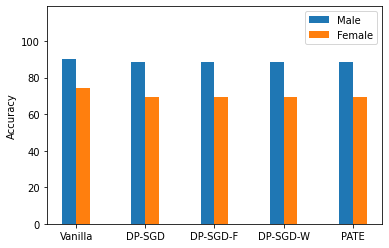

In [52]:
model_names = ["Vanilla", "DP-SGD", "DP-SGD-F", "DP-SGD-W", "PATE"]
models = [model_vanilla, model_dpsgd, model_dpsgdf, model_dpsgd_w, model_pate]
preds = []
for model in models:
    preds.append(pf.utils.evaluate_model(model, test_loader))


accuracies = {c: np.zeros(len(model_names)) for c in np.unique(test_gender)}
for i, model in enumerate(zip(model_names, preds)):
    correct_mask = preds[i] == y_test
    for c in accuracies.keys():
        class_mask = test_gender == c
        accuracies[c][i] = np.sum(correct_mask & class_mask) / np.sum(class_mask)

width = 0.2
ind = np.arange(len(model_names))
for i, c in enumerate(accuracies.keys()):
    plt.bar(ind + width * i, accuracies[c] * 100, width, label=str(c))

plt.ylabel("Accuracy")
plt.legend(["Male", "Female"])
plt.xticks(ind + width * (len(accuracies.keys()) - 1) / 2, model_names)
plt.ylim(0, 119)
plt.show()